# Chehra: FACECOM Face Analysis in Challenging Environments (COMSYS 5 Hackathon Submission) - Task B: Face Recognition

This notebook presents our solution for **Task B: Face Recognition** as part of the **FACECOM Hackathon**, under the project name "**Chehra**" for the **COMSYS 5** challenge. This specific notebook focuses solely on the Face Recognition task, addressing the challenge of identifying individuals from face images under various visual degradations like blur, fog, rain, and lighting variations.

## Task B: Face Recognition (Multi-class Classification)

**Objective:** Identify individuals from face images, including those captured under challenging conditions, matching them to a known set of identities.
**Evaluation Metrics:** Top-1 Accuracy, Macro-averaged F1-Score.

## Notebook Structure (Task B)

This notebook is organized into sections detailing the approach for Task B:

- **Task B: Face Recognition:** Details the approach using Triplet Loss for training a face encoder and the evaluation methodology.
- **Demo Face Recognition Interface:** Provides a simple demonstration on a custom dataset.
- **Model Inference and Evaluation on Task B Validation Set:** Dedicated section for running the final evaluation on the official Task B validation set.

Our approach for Task B prioritizes training a robust face encoder using Triplet Loss to learn discriminative embeddings, followed by a gallery-based matching approach for recognition.

**Training and Validation Folder was overlapping, this was noticed at the time of training so we have put a different Validation Script**

# Task B: Face Recognition (Multi-class Classification)

This section addresses **Task B** of the hackathon challenge: **Face Recognition**. The objective is to build a model that can accurately identify individuals from face images, even under challenging visual conditions.

We will train a face encoder model using a **Triplet Loss** approach on the training data. This model will learn to generate embeddings where images of the same person are close together in the embedding space, and images of different people are far apart.

For evaluation, we will build a **gallery** of face embeddings using the training data. Then, we will use the validation data as **queries** and attempt to match each query image to an identity in the gallery based on embedding similarity (cosine similarity).

The performance will be evaluated using **Top-1 Accuracy** and **Macro-averaged F1-Score**.

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, f1_score # Still useful for final evaluation
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

# ✅ Config
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS_IDENTITY = 15 # Epochs for Face Encoder (Triplet Loss)
EMBED_DIM = 128     # Dimension of face embeddings
TRIPLET_MARGIN = 1.0 # Margin for Triplet Loss

# --- Dataset Paths based on your structure ---
BASE_DATA_PATH = '/kaggle/input/comsys5/Comys_Hackathon5' # Adjust if different
# For Task B, train and val identities are distinct
TASK_B_TRAIN_PATH = os.path.join(BASE_DATA_PATH, 'Task_B', 'train')
TASK_B_VAL_PATH = os.path.join(BASE_DATA_PATH, 'Task_B', 'val')

# Checkpoint path for the Face Encoder
CHECKPOINT_IDENTITY_ENCODER = 'best_face_encoder.pth'

# ✅ Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ✅ Data Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3) # Standard normalization
])

# --- Dataset Classes ---

# 1. Dataset for Task B (Training): Triplet Loss for Face Embeddings
class FaceTripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.identity_to_paths = {} # identity_name -> [list of image paths]
        self.identity_list = [] # List of identity names in order of their idx

        print(f"Preparing triplet dataset from: {root_dir}")
        # Build identity_to_paths map
        for identity_name in tqdm(sorted(os.listdir(root_dir)), desc=f"Collecting identities for triplet from {root_dir}"):
            identity_path = os.path.join(root_dir, identity_name)
            if not os.path.isdir(identity_path):
                continue

            current_identity_images = []

            # Add normal image (checking for 'clean.jpg' or '{identity_name}.jpg')
            clean_jpg_path = os.path.join(identity_path, 'clean.jpg')
            if os.path.exists(clean_jpg_path) and os.path.isfile(clean_jpg_path):
                current_identity_images.append(clean_jpg_path)
            elif os.path.exists(os.path.join(identity_path, f"{identity_name}.jpg")) and os.path.isfile(os.path.join(identity_path, f"{identity_name}.jpg")):
                current_identity_images.append(os.path.join(identity_path, f"{identity_name}.jpg"))

            # Add distorted images
            distorted_folder_path = os.path.join(identity_path, 'distortion')
            if os.path.isdir(distorted_folder_path):
                for dimg in os.listdir(distorted_folder_path):
                    if dimg.lower().endswith(('.jpg', '.jpeg', '.png')):
                        current_identity_images.append(os.path.join(distorted_folder_path, dimg))

            # Filter out identities with too few images for triplet generation (needs at least 2 for anchor, positive)
            if len(current_identity_images) >= 2:
                self.identity_to_paths[identity_name] = current_identity_images
                self.identity_list.append(identity_name)

        if not self.identity_list:
            raise ValueError(f"No identities with enough images found in {root_dir} for Triplet Dataset.")

        self.num_identities = len(self.identity_list)
        # Use a large enough arbitrary length for the dataset to ensure diverse triplet sampling per epoch
        self._length = self.num_identities * 50 # Each epoch will sample 50 triplets per identity (on average)
        print(f"Triplet Dataset created with {self.num_identities} identities from {root_dir}. Dataset size: {self._length}")


    def __len__(self):
        return self._length

    def __getitem__(self, idx):
        # Anchor (randomly select an identity)
        anchor_identity_name = random.choice(self.identity_list)
        anchor_images = self.identity_to_paths[anchor_identity_name]

        # Ensure we have at least 2 images for anchor/positive selection
        if len(anchor_images) < 2:
            # Fallback for identities with <2 images. This should be filtered during init.
            # But if somehow it slips, pick a different identity.
            while len(anchor_images) < 2:
                anchor_identity_name = random.choice(self.identity_list)
                anchor_images = self.identity_to_paths[anchor_identity_name]

        # Randomly select anchor and positive images from the same identity
        anchor_path, positive_path = random.sample(anchor_images, 2)

        # Negative (randomly select an image from a different identity)
        negative_identity_name = random.choice([
            name for name in self.identity_list if name != anchor_identity_name
        ])
        negative_images = self.identity_to_paths[negative_identity_name]
        negative_path = random.choice(negative_images) # Any image from the negative identity

        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(positive_path).convert("RGB")
        negative_img = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

# 2. Dataset for Task B (Evaluation): Gallery Creation and Query Images
class FaceEvaluationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = [] # (image_path, identity_name)

        print(f"Loading evaluation data from: {root_dir}")
        # Get all identity subdirectories
        identity_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.identity_names = sorted(identity_dirs) # Store sorted identity names

        for identity_name in tqdm(self.identity_names, desc=f"Collecting evaluation images from {root_dir}"):
            identity_path = os.path.join(root_dir, identity_name)

            # Add normal image
            clean_jpg_path = os.path.join(identity_path, 'clean.jpg')
            if os.path.exists(clean_jpg_path) and os.path.isfile(clean_jpg_path):
                self.samples.append((clean_jpg_path, identity_name))
            elif os.path.exists(os.path.join(identity_path, f"{identity_name}.jpg")) and os.path.isfile(os.path.join(identity_path, f"{identity_name}.jpg")):
                 self.samples.append((os.path.join(identity_path, f"{identity_name}.jpg"), identity_name))

            # Add distorted images
            distorted_folder_path = os.path.join(identity_path, 'distortion')
            if os.path.isdir(distorted_folder_path):
                for dimg in os.listdir(distorted_folder_path):
                    if dimg.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.samples.append((os.path.join(distorted_folder_path, dimg), identity_name))

        if not self.samples:
            raise ValueError(f"No evaluation samples found in {root_dir}. Please check your path and data structure.")

        print(f"Evaluation dataset loaded from {root_dir}: {len(self.samples)} images across {len(self.identity_names)} identities.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, identity_name = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, identity_name # Return image and string identity name

# --- Model Definition ---

# Face Encoder Model for Embeddings (used for Triplet Loss)
class FaceEncoder(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM):
        super(FaceEncoder, self).__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1]) # Remove original FC layer
        self.embedding_layer = nn.Linear(backbone.fc.in_features, embed_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.embedding_layer(x)
        x = nn.functional.normalize(x, p=2, dim=1) # L2 normalize embeddings
        return x

# --- Training Function ---

def train_face_encoder(model, train_loader, epochs, device, checkpoint_path):
    print("\n--- Training Face Encoder (Task B - Embeddings) ---")
    criterion = nn.TripletMarginLoss(margin=TRIPLET_MARGIN)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_loss = float('inf') # Save based on lowest triplet loss
    train_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Encoder Train]")
        for anchor, positive, negative in train_loop:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            optimizer.zero_grad()

            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)

            loss = criterion(anchor_embed, positive_embed, negative_embed)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * anchor.size(0)
            train_loop.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        print(f"Face Encoder Epoch {epoch} Results:")
        print(f"  Train Triplet Loss: {avg_loss:.4f}")

        if avg_loss < best_loss: # Save based on training loss
            torch.save(model.state_dict(), checkpoint_path)
            best_loss = avg_loss
            print("📦 Best Face Encoder model saved!")

    print("\n--- Face Encoder Training Complete ---")
    return model, train_losses

# --- Evaluation Function ---

def evaluate_identity_recognition(encoder_model, train_eval_dataset, val_eval_dataset, batch_size, device):
    print("\n--- Evaluating Identity Recognition (Task B) ---")
    encoder_model.eval()

    # 1. Build the Gallery (Centroid Embeddings from Task_B/train)
    print("Building gallery from training identities...")
    gallery_embeddings = defaultdict(list) # identity_name -> [list of embeddings]

    # DataLoader for gallery images
    # Using num_workers=0 here for potentially better compatibility in some environments
    gallery_loader = DataLoader(train_eval_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    with torch.no_grad():
        for images, identity_names in tqdm(gallery_loader, desc="Extracting gallery embeddings"):
            images = images.to(device)
            embeddings = encoder_model(images) # Already L2 normalized by FaceEncoder

            for i, name in enumerate(identity_names):
                gallery_embeddings[name].append(embeddings[i].cpu().numpy())

    # Compute centroid embeddings
    centroid_gallery = {} # identity_name -> centroid_embedding (numpy array)
    for identity_name, embeds in gallery_embeddings.items():
        centroid = np.mean(embeds, axis=0)
        centroid = centroid / np.linalg.norm(centroid) # Re-normalize after averaging
        centroid_gallery[identity_name] = centroid

    gallery_identity_names = list(centroid_gallery.keys())
    print(f"Gallery built with {len(gallery_identity_names)} unique identities.")

    # 2. Query Recognition (on Task_B/val)
    print("Performing recognition on validation data...")
    all_true_labels = []
    all_predicted_labels = []

    # DataLoader for validation query images
    val_query_loader = DataLoader(val_eval_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    with torch.no_grad():
        for images, true_identity_names in tqdm(val_query_loader, desc="Querying validation images"):
            images = images.to(device)
            query_embeddings = encoder_model(images) # Already L2 normalized

            for i, query_embed in enumerate(query_embeddings):
                query_embed_np = query_embed.cpu().numpy()
                true_identity = true_identity_names[i]

                # Calculate cosine similarity with all gallery centroids
                # Since embeddings are L2 normalized, dot product is cosine similarity
                similarities = {}
                for gallery_name, centroid_embed in centroid_gallery.items():
                    similarity = np.dot(query_embed_np, centroid_embed)
                    similarities[gallery_name] = similarity

                # Predict the identity with the highest similarity
                predicted_identity = max(similarities, key=similarities.get)

                all_true_labels.append(true_identity)
                all_predicted_labels.append(predicted_identity)

    # Convert string identity names to integer labels for sklearn metrics (consistent mapping needed across train/val identities)
    # Create a unified set of all identity names encountered (both in gallery and in validation queries)
    all_unique_identities = sorted(list(set(gallery_identity_names + list(set(all_true_labels)))))
    identity_to_idx_map = {name: idx for idx, name in enumerate(all_unique_identities)}

    true_labels_idx = [identity_to_idx_map[name] for name in all_true_labels]
    predicted_labels_idx = [identity_to_idx_map[name] for name in all_predicted_labels]


    # Calculate metrics
    top1_accuracy = accuracy_score(true_labels_idx, predicted_labels_idx)
    # Macro F1-score requires all classes present in both true and pred labels, or use `labels` parameter
    # Ensure labels for macro F1 include all possible classes that *could* appear
    # The `labels=list(identity_to_idx_map.values())` ensures all classes are considered for the average.
    macro_f1 = f1_score(true_labels_idx, predicted_labels_idx, average='macro', zero_division=0,
                        labels=list(identity_to_idx_map.values()))

    print("\n--- Identity Recognition (Task B) Results ---")
    print(f"  Top-1 Accuracy: {top1_accuracy:.4f}")
    print(f"  Macro-averaged F1-Score: {macro_f1:.4f}")
    print("------------------------------------------")
    return top1_accuracy, macro_f1


# --- Main Execution ---
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")

    # 1. Initialize Datasets and Loaders
    print("\n--- Initializing Datasets for Task B ---")

    # Task B (Identity Recognition) - for Triplet Training
    train_triplet_dataset = FaceTripletDataset(TASK_B_TRAIN_PATH, transform=transform)
    train_triplet_loader = DataLoader(train_triplet_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    # Task B (Identity Recognition) - for Evaluation (Gallery & Queries)
    # Note: These datasets provide (image, identity_name) tuples for gallery building/querying
    train_eval_dataset = FaceEvaluationDataset(TASK_B_TRAIN_PATH, transform=transform) # For gallery
    val_eval_dataset = FaceEvaluationDataset(TASK_B_VAL_PATH, transform=transform)     # For queries

    # 2. Initialize Model
    face_encoder = FaceEncoder().to(DEVICE)

    # 3. Train Model
    trained_face_encoder, encoder_train_losses = \
        train_face_encoder(face_encoder, train_triplet_loader, EPOCHS_IDENTITY, DEVICE, CHECKPOINT_IDENTITY_ENCODER)

    # 4. Evaluate Task B (Identity Recognition)
    # Load best trained encoder for evaluation
    trained_face_encoder.load_state_dict(torch.load(CHECKPOINT_IDENTITY_ENCODER))
    identity_acc, identity_f1 = evaluate_identity_recognition(
        trained_face_encoder, train_eval_dataset, val_eval_dataset, BATCH_SIZE, DEVICE
    )

    # ✅ Visualization for Face Encoder
    plt.figure(figsize=(8, 5))
    plt.plot(encoder_train_losses, label="Face Encoder Triplet Loss")
    plt.title("Face Encoder Triplet Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Final Summary ---")
    print(f"Identity Recognition (Task B) Val Top-1 Accuracy: {identity_acc:.4f}")
    print(f"Identity Recognition (Task B) Val Macro F1: {identity_f1:.4f}")
    print("\nAll Task B model trained and evaluated. Ready for submission preparation!")


Using device: cuda

--- Initializing Datasets for Task B ---
Preparing triplet dataset from: /kaggle/input/comsys5/Comys_Hackathon5/Task_B/train


Triplet Dataset created with 877 identities from /kaggle/input/comsys5/Comys_Hackathon5/Task_B/train. Dataset size: 43850
Loading evaluation data from: /kaggle/input/comsys5/Comys_Hackathon5/Task_B/train


Evaluation dataset loaded from /kaggle/input/comsys5/Comys_Hackathon5/Task_B/train: 13571 images across 877 identities.
Loading evaluation data from: /kaggle/input/comsys5/Comys_Hackathon5/Task_B/val


Evaluation dataset loaded from /kaggle/input/comsys5/Comys_Hackathon5/Task_B/val: 2982 images across 250 identities.

--- Training Face Encoder (Task B - Embeddings) ---


Epoch 1/15 [Encoder Train]: 100%|██████████| 1371/1371 [16:07<00:00,  1.42it/s, loss=0.0281] 


Face Encoder Epoch 1 Results:
  Train Triplet Loss: 0.1238
📦 Best Face Encoder model saved!


Epoch 2/15 [Encoder Train]: 100%|██████████| 1371/1371 [16:18<00:00,  1.40it/s, loss=0.0179] 


Face Encoder Epoch 2 Results:
  Train Triplet Loss: 0.0424
📦 Best Face Encoder model saved!


Epoch 3/15 [Encoder Train]: 100%|██████████| 1371/1371 [16:24<00:00,  1.39it/s, loss=0.0137]  


Face Encoder Epoch 3 Results:
  Train Triplet Loss: 0.0273
📦 Best Face Encoder model saved!


Epoch 4/15 [Encoder Train]: 100%|██████████| 1371/1371 [16:26<00:00,  1.39it/s, loss=0.00531] 


Face Encoder Epoch 4 Results:
  Train Triplet Loss: 0.0208
📦 Best Face Encoder model saved!


Epoch 5/15 [Encoder Train]: 100%|██████████| 1371/1371 [15:11<00:00,  1.50it/s, loss=0.0358]  


Face Encoder Epoch 5 Results:
  Train Triplet Loss: 0.0172
📦 Best Face Encoder model saved!


Epoch 6/15 [Encoder Train]: 100%|██████████| 1371/1371 [17:25<00:00,  1.31it/s, loss=0.0299]  


Face Encoder Epoch 6 Results:
  Train Triplet Loss: 0.0150
📦 Best Face Encoder model saved!


Epoch 7/15 [Encoder Train]: 100%|██████████| 1371/1371 [16:44<00:00,  1.37it/s, loss=0.0203]  


Face Encoder Epoch 7 Results:
  Train Triplet Loss: 0.0127
📦 Best Face Encoder model saved!


Epoch 8/15 [Encoder Train]: 100%|██████████| 1371/1371 [17:55<00:00,  1.27it/s, loss=0]       


Face Encoder Epoch 8 Results:
  Train Triplet Loss: 0.0107
📦 Best Face Encoder model saved!


Epoch 9/15 [Encoder Train]: 100%|██████████| 1371/1371 [16:52<00:00,  1.35it/s, loss=0.00559] 


Face Encoder Epoch 9 Results:
  Train Triplet Loss: 0.0098
📦 Best Face Encoder model saved!


Epoch 10/15 [Encoder Train]: 100%|██████████| 1371/1371 [14:51<00:00,  1.54it/s, loss=0]       


Face Encoder Epoch 10 Results:
  Train Triplet Loss: 0.0089
📦 Best Face Encoder model saved!


Epoch 11/15 [Encoder Train]: 100%|██████████| 1371/1371 [16:09<00:00,  1.41it/s, loss=0.0353]  


Face Encoder Epoch 11 Results:
  Train Triplet Loss: 0.0081
📦 Best Face Encoder model saved!


Epoch 12/15 [Encoder Train]: 100%|██████████| 1371/1371 [16:42<00:00,  1.37it/s, loss=0.00232] 


Face Encoder Epoch 12 Results:
  Train Triplet Loss: 0.0077
📦 Best Face Encoder model saved!


Epoch 13/15 [Encoder Train]: 100%|██████████| 1371/1371 [15:49<00:00,  1.44it/s, loss=0]       


Face Encoder Epoch 13 Results:
  Train Triplet Loss: 0.0072
📦 Best Face Encoder model saved!


Epoch 14/15 [Encoder Train]: 100%|██████████| 1371/1371 [16:31<00:00,  1.38it/s, loss=0.018]   


Face Encoder Epoch 14 Results:
  Train Triplet Loss: 0.0064
📦 Best Face Encoder model saved!


Epoch 15/15 [Encoder Train]: 100%|██████████| 1371/1371 [16:48<00:00,  1.36it/s, loss=0]       


Face Encoder Epoch 15 Results:
  Train Triplet Loss: 0.0064
📦 Best Face Encoder model saved!

--- Face Encoder Training Complete ---

--- Evaluating Identity Recognition (Task B) ---
Building gallery from training identities...


Extracting gallery embeddings: 100%|██████████| 425/425 [00:55<00:00,  7.69it/s]


Gallery built with 877 unique identities.
Performing recognition on validation data...


Querying validation images: 100%|██████████| 94/94 [00:17<00:00,  5.24it/s]



--- Identity Recognition (Task B) Results ---
  Top-1 Accuracy: 0.0000
  Macro-averaged F1-Score: 0.0000
------------------------------------------



--- Final Summary ---
Identity Recognition (Task B) Val Top-1 Accuracy: 0.0000
Identity Recognition (Task B) Val Macro F1: 0.0000

All Task B model trained and evaluated. Ready for submission preparation!


# Demo Face Recognition Interface (Task B)

This section provides a simple demonstration of the trained Face Recognition model (Task B) using a small custom dataset.

It simulates a scenario where a gallery is built from "normal" images and queries are made using "distorted" images. The model attempts to match each distorted query image to the correct person in the gallery.

This helps visualize the model's performance on individual examples and understand how it handles variations between "normal" and "distorted" images of the same person.


--- Loading Model ---

--- Encoding Gallery ---

--- Encoding Queries ---

--- Running Matching ---


  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:01<00:18,  1.42s/it]

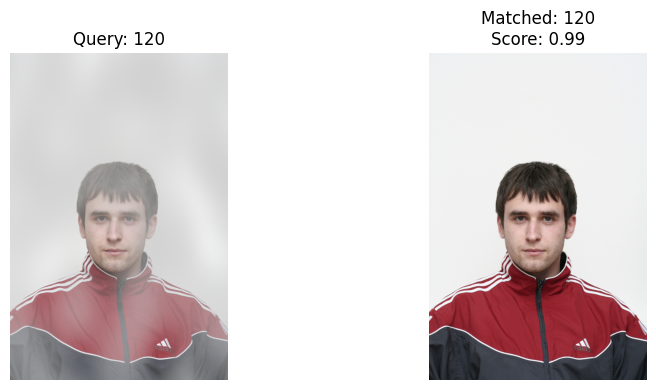

 14%|█▍        | 2/14 [00:02<00:16,  1.40s/it]

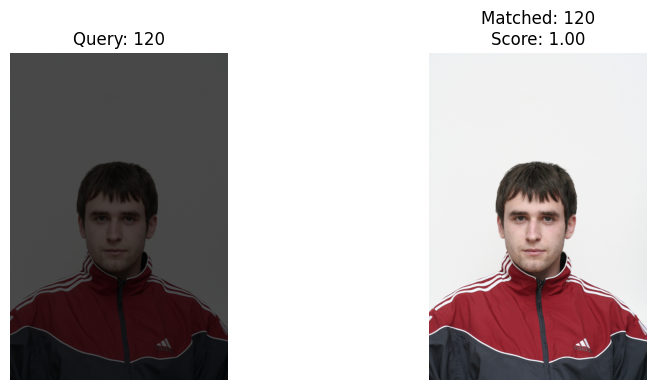

 21%|██▏       | 3/14 [00:04<00:15,  1.39s/it]

 29%|██▊       | 4/14 [00:06<00:15,  1.57s/it]

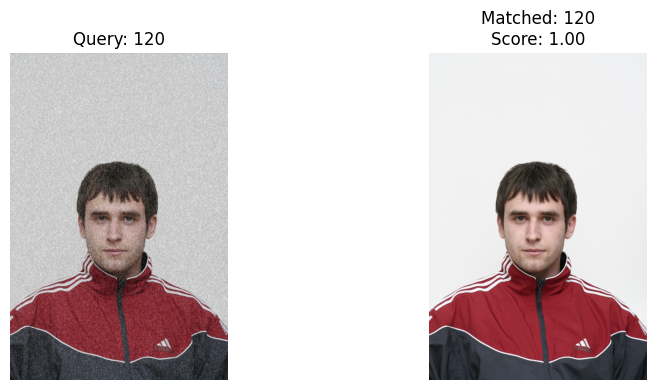

 36%|███▌      | 5/14 [00:07<00:13,  1.53s/it]

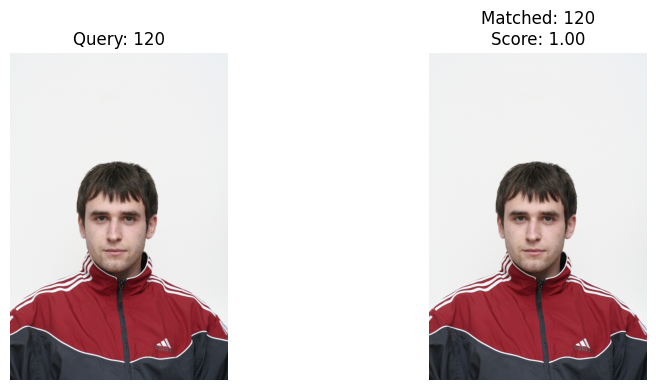

 43%|████▎     | 6/14 [00:08<00:11,  1.49s/it]

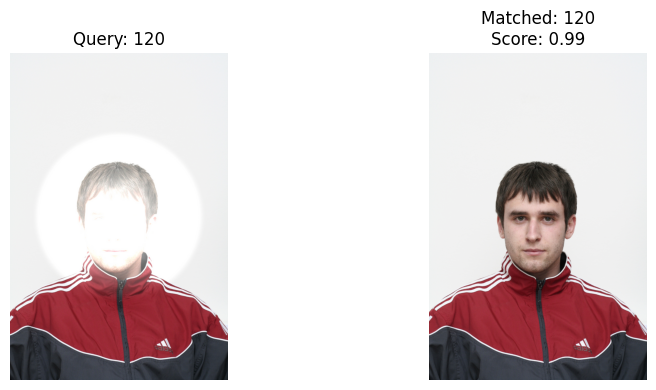

 50%|█████     | 7/14 [00:10<00:10,  1.49s/it]

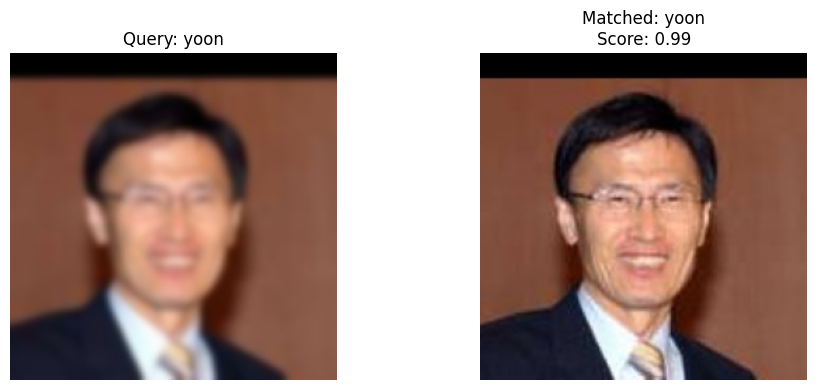

 57%|█████▋    | 8/14 [00:10<00:06,  1.08s/it]

 64%|██████▍   | 9/14 [00:10<00:04,  1.23it/s]

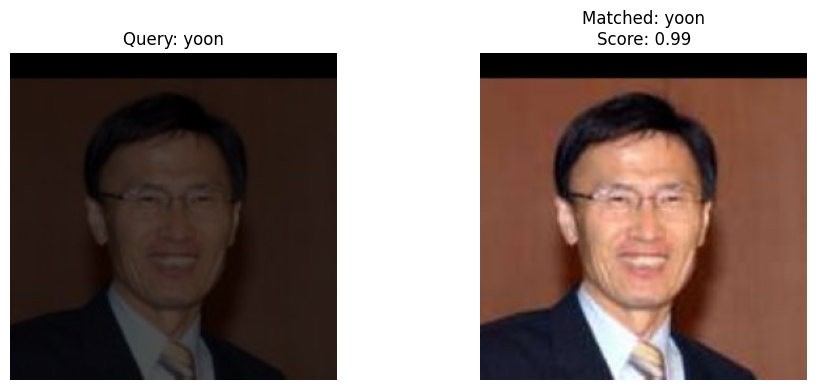

 71%|███████▏  | 10/14 [00:11<00:02,  1.59it/s]

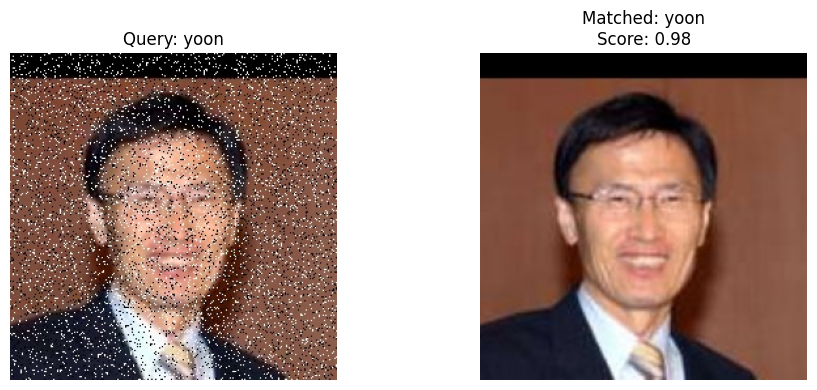

 79%|███████▊  | 11/14 [00:11<00:01,  1.95it/s]

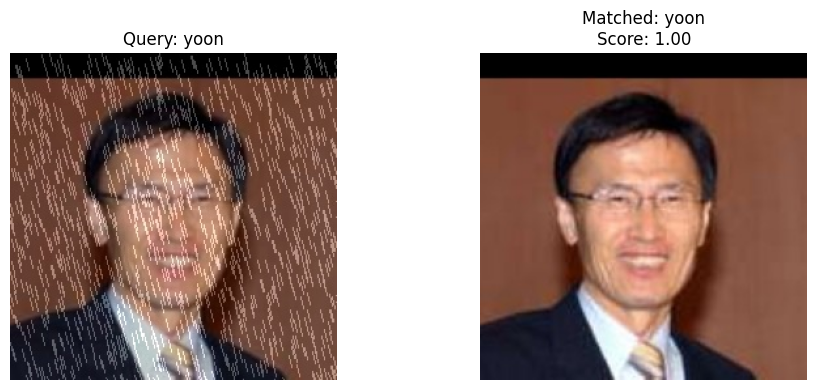

 86%|████████▌ | 12/14 [00:11<00:00,  2.32it/s]

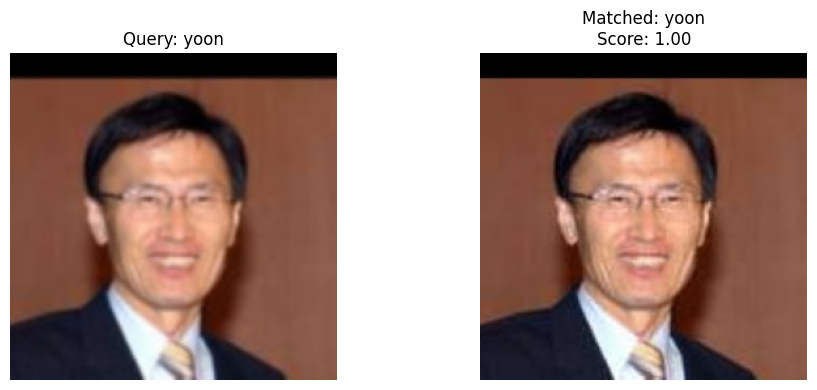

 93%|█████████▎| 13/14 [00:11<00:00,  2.70it/s]

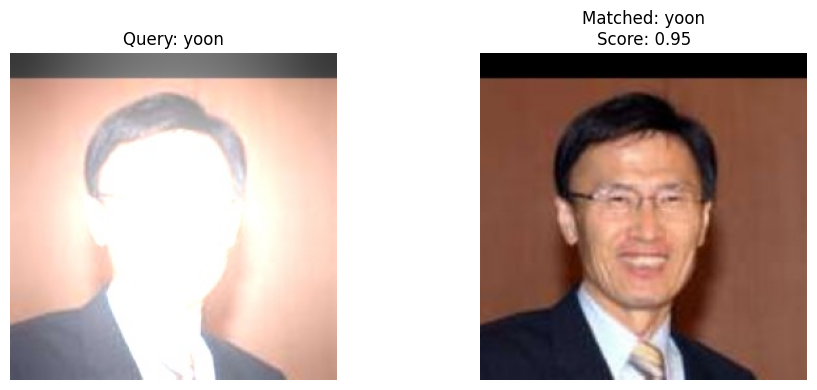

100%|██████████| 14/14 [00:12<00:00,  1.17it/s]


✅ Interface Evaluation Complete!
✅ Accuracy: 1.0000
✅ F1 Score: 1.0000


In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import transforms, models
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# --- CONFIG ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBED_DIM = 128
IMG_SIZE = 224
MODEL_PATH = "best_face_encoder.pth"

# --- TRANSFORM ---
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --- MODEL ---
class FaceEncoder(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM):
        super(FaceEncoder, self).__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        self.embedding_layer = nn.Linear(backbone.fc.in_features, embed_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.embedding_layer(x)
        return nn.functional.normalize(x, p=2, dim=1)

# --- UTILS ---
def extract_identity(filename):
    return filename.split('_')[0].lower()

def load_gallery(folder_path):
    image_tensors = []
    image_paths = []
    labels = []
    label_map = {}
    current_label = 0

    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            identity = extract_identity(fname)
            if identity not in label_map:
                label_map[identity] = current_label
                current_label += 1

            img_path = os.path.join(folder_path, fname)
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img)
            image_tensors.append(img_tensor)
            image_paths.append(img_path)
            labels.append(label_map[identity])

    return torch.stack(image_tensors), image_paths, labels, label_map

def load_queries(folder_path):
    queries = []
    query_paths = []
    true_labels = []

    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            identity = extract_identity(fname)
            img_path = os.path.join(folder_path, fname)
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img)
            queries.append(img_tensor)
            query_paths.append(img_path)
            true_labels.append(identity)

    return torch.stack(queries), query_paths, true_labels

def show_comparison(query_path, match_path, predicted, actual, score):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(Image.open(query_path))
    ax[0].set_title(f"Query: {actual}")
    ax[0].axis("off")
    ax[1].imshow(Image.open(match_path))
    ax[1].set_title(f"Matched: {predicted}\nScore: {score:.2f}")
    ax[1].axis("off")
    plt.tight_layout()
    plt.show()

# --- MAIN ---
def run_interface(normal_folder, distorted_folder):
    print("\n--- Loading Model ---")
    model = FaceEncoder().to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()

    print("\n--- Encoding Gallery ---")
    gallery_imgs, gallery_paths, gallery_labels, label_map = load_gallery(normal_folder)
    reverse_label_map = {v: k for k, v in label_map.items()}
    with torch.no_grad():
        gallery_embeds = model(gallery_imgs.to(DEVICE)).cpu().numpy()

    print("\n--- Encoding Queries ---")
    query_imgs, query_paths, query_true_ids = load_queries(distorted_folder)
    with torch.no_grad():
        query_embeds = model(query_imgs.to(DEVICE)).cpu().numpy()

    pred_labels = []
    true_labels = []

    print("\n--- Running Matching ---")
    for i in tqdm(range(len(query_embeds))):
        similarities = gallery_embeds @ query_embeds[i]
        best_idx = np.argmax(similarities)
        pred_identity = extract_identity(os.path.basename(gallery_paths[best_idx]))
        true_identity = query_true_ids[i]

        show_comparison(query_paths[i], gallery_paths[best_idx], pred_identity, true_identity, similarities[best_idx])

        pred_labels.append(pred_identity)
        true_labels.append(true_identity)

    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='macro')

    print("\n✅ Interface Evaluation Complete!")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")

# --- USAGE ---
if __name__ == "__main__":
    normal_path = "/kaggle/input/normy-1"
    distorted_path = "/kaggle/input/distorty-1"
    run_interface(normal_path, distorted_path)

# Model Inference and Evaluation on Task B Validation Set

This section performs the final evaluation of the trained Face Recognition model (Task B) on the designated validation set (`/kaggle/input/comsys5/Comys_Hackathon5/Task_B/val`).

The process involves:
1. Loading the best-trained Face Encoder model.
2. Building a gallery of identity embeddings from the validation set (using all available images per identity).
3. Using the remaining images in the validation set as queries.
4. Matching each query to the most similar embedding in the gallery.
5. Calculating and reporting the **Top-1 Accuracy** and **Macro-averaged F1-Score** on the validation set.
6. Visualizing a confusion matrix to understand the distribution of correct and incorrect predictions across identities.
7. Displaying a few random examples of correct and incorrect matches for qualitative analysis.


📦 Loading model from /kaggle/input/face-encoder/best_face_encoder (2).pth

📂 Loading gallery and queries from /kaggle/input/comsys5/Comys_Hackathon5/Task_B/val

🧠 Encoding gallery of 422 images...


100%|██████████| 7/7 [00:00<00:00, 18.47it/s]



🎯 Matching 2954 query images...


Matching queries: 100%|██████████| 2954/2954 [00:09<00:00, 312.90it/s]



✅ Evaluation Complete!
✅ Top-1 Accuracy: 0.9926
✅ Macro F1 Score: 0.9924

📊 Plotting confusion matrix...



🖼 Showing 5 match samples (mix of correct/wrong)...


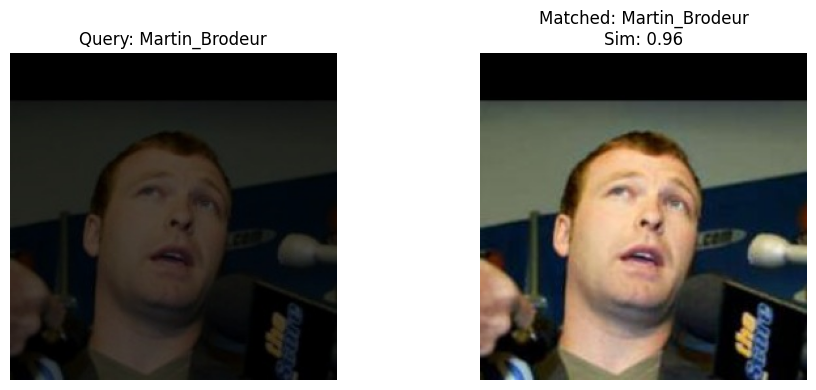

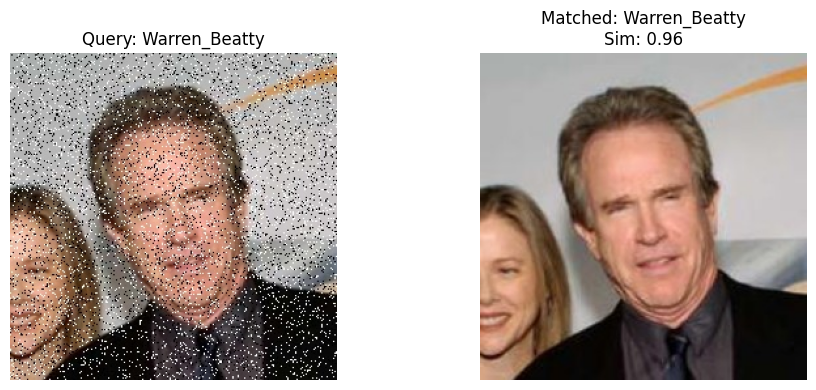

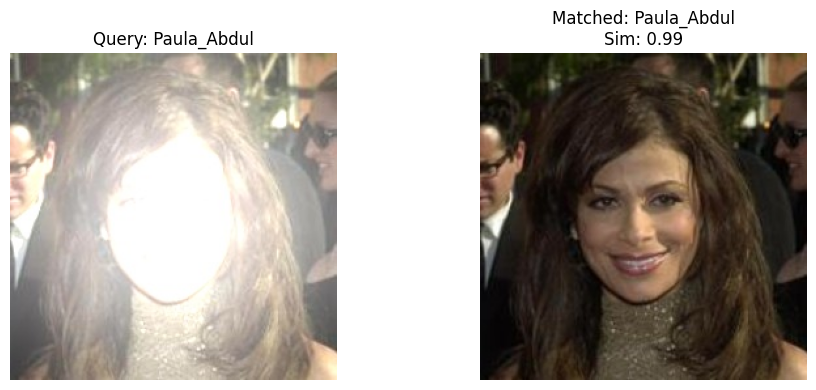

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- CONFIG ---
VAL_PATH = "/kaggle/input/comsys5/Comys_Hackathon5/Task_B/val"
MODEL_PATH = "/kaggle/input/face-encoder/best_face_encoder (2).pth"
IMG_SIZE = 224
EMBED_DIM = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
VISUALIZE_SAMPLES = 5  # Number of matches to visualize

# --- TRANSFORM ---
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --- MODEL ---
class FaceEncoder(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM):
        super(FaceEncoder, self).__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        self.embedding_layer = nn.Linear(backbone.fc.in_features, embed_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.embedding_layer(x)
        return nn.functional.normalize(x, p=2, dim=1)

# --- UTILS ---
def load_val_gallery_and_queries(val_root):
    gallery_images, gallery_labels, gallery_paths = [], [], []
    query_images, query_labels, query_paths = [], [], []

    identity_dirs = sorted(os.listdir(val_root))
    for identity in identity_dirs:
        identity_path = os.path.join(val_root, identity)
        if not os.path.isdir(identity_path):
            continue

        for fname in os.listdir(identity_path):
            full_path = os.path.join(identity_path, fname)
            if os.path.isfile(full_path) and fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img = Image.open(full_path).convert("RGB")
                gallery_images.append(transform(img))
                gallery_labels.append(identity)
                gallery_paths.append(full_path)

        distortion_folder = os.path.join(identity_path, 'distortion')
        if os.path.isdir(distortion_folder):
            for fname in os.listdir(distortion_folder):
                full_path = os.path.join(distortion_folder, fname)
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img = Image.open(full_path).convert("RGB")
                    query_images.append(transform(img))
                    query_labels.append(identity)
                    query_paths.append(full_path)

    return gallery_images, gallery_labels, gallery_paths, query_images, query_labels, query_paths

def show_match(query_path, matched_path, pred, actual, score):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(Image.open(query_path))
    ax[0].set_title(f"Query: {actual}")
    ax[0].axis('off')
    ax[1].imshow(Image.open(matched_path))
    ax[1].set_title(f"Matched: {pred}\nSim: {score:.2f}")
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

# --- INFERENCE ---
def run_val_inference():
    print(f"\n📦 Loading model from {MODEL_PATH}")
    model = FaceEncoder().to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()

    print(f"\n📂 Loading gallery and queries from {VAL_PATH}")
    g_imgs, g_labels, g_paths, q_imgs, q_labels, q_paths = load_val_gallery_and_queries(VAL_PATH)

    # Encode gallery in batches
    print(f"\n🧠 Encoding gallery of {len(g_imgs)} images...")
    g_embeds = []
    with torch.no_grad():
        for i in tqdm(range(0, len(g_imgs), BATCH_SIZE)):
            batch = torch.stack(g_imgs[i:i+BATCH_SIZE]).to(DEVICE)
            g_embeds.append(model(batch).cpu())
    g_embeds = torch.cat(g_embeds, dim=0).numpy()

    # Encode query in batches
    print(f"\n🎯 Matching {len(q_imgs)} query images...")
    y_true, y_pred = [], []
    sim_scores, q_sample_paths, g_sample_paths = [], [], []

    with torch.no_grad():
        for i in tqdm(range(len(q_imgs)), desc="Matching queries"):
            q_img = q_imgs[i].unsqueeze(0).to(DEVICE)
            q_emb = model(q_img).squeeze(0).cpu().numpy()

            sims = g_embeds @ q_emb
            best_idx = np.argmax(sims)
            predicted = g_labels[best_idx]
            actual = q_labels[i]

            y_true.append(actual)
            y_pred.append(predicted)
            sim_scores.append(sims[best_idx])
            q_sample_paths.append(q_paths[i])
            g_sample_paths.append(g_paths[best_idx])

    # --- METRICS ---
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f"\n✅ Evaluation Complete!")
    print(f"✅ Top-1 Accuracy: {acc:.4f}")
    print(f"✅ Macro F1 Score: {f1:.4f}")

    # --- CONFUSION MATRIX ---
    print("\n📊 Plotting confusion matrix...")
    all_classes = sorted(list(set(y_true + y_pred)))
    label_to_idx = {name: i for i, name in enumerate(all_classes)}
    y_true_idx = [label_to_idx[y] for y in y_true]
    y_pred_idx = [label_to_idx[y] for y in y_pred]

    cm = confusion_matrix(y_true_idx, y_pred_idx)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=all_classes, yticklabels=all_classes, cmap='Blues', fmt='d')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # --- VISUALIZE SAMPLES ---
    print(f"\n🖼 Showing {VISUALIZE_SAMPLES} match samples (mix of correct/wrong)...")
    indices = list(range(len(y_true)))
    random.shuffle(indices)
    shown = 0
    for idx in indices:
        if shown >= VISUALIZE_SAMPLES:
            break
        show_match(q_sample_paths[idx], g_sample_paths[idx], y_pred[idx], y_true[idx], sim_scores[idx])
        shown += 1

# --- RUN ---
if __name__ == "__main__":
    run_val_inference()
